# N170 analysis only

This notebook runs only the data analysis part of N170 notebook.

Look at the notes to see how this can be run on the web with binder or google collab. 

All of the additional notes are removed; only the code cells are kept.  

In [1]:
from muselsl import stream, list_muses, view, record
from multiprocessing import Process
from mne import Epochs, find_events
from time import time, strftime, gmtime
import os
#from stimulus_presentation import n170
os.chdir('../')
from utils import utils
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')

---

Skipping these steps 

- Step 1: Connect to an EEG Device
- Step 2: Apply the EEG Device and Wait for Signal Quality to Stabilize
- Step 3: Run the Experiment


---

Load data

In [2]:
subject = 1
session = 1

#raw = utils.load_data('visual/N170', sfreq=256., 
raw = utils.load_data('../data/visual/N170', sfreq=256., 
                      subject_nb=subject, session_nb=session)

Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30720
    Range : 0 ... 30719 =      0.000 ...   119.996 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.


Visualize the power spectrum

Effective window size : 8.000 (s)


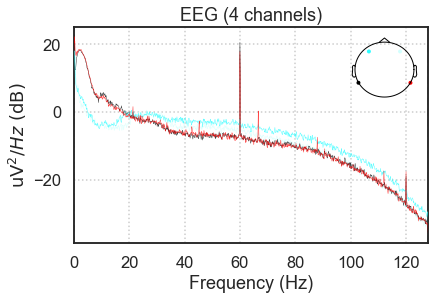

In [3]:
%matplotlib inline
raw.plot_psd();

Filtering

Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Setting up band-pass filter from 1 - 30 Hz
Effective window size : 8.000 (s)


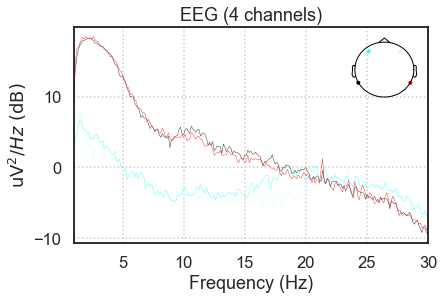

In [4]:
raw.filter(1,30, method='iir')
raw.plot_psd(fmin=1, fmax=30);

Epoching

In [5]:
# Create an array containing the timestamps and type of each stimulus (i.e. face or house)
events = find_events(raw)
event_id = {'House': 1, 'Face': 2}

# Create an MNE Epochs object representing all the epochs around stimulus presentation
epochs = Epochs(raw, events=events, event_id=event_id, 
                tmin=-0.1, tmax=0.8, baseline=None,
                reject={'eeg': 75e-6}, preload=True, 
                verbose=False, picks=[0,1,2,3])
print('sample drop %: ', (1 - len(epochs.events)/len(events)) * 100)
epochs

1174 events found
Event IDs: [1 2]
('sample drop %: ', 100)


<Epochs  |   1127 events (all good), -0.101562 - 0.800781 sec, baseline off, ~8.0 MB, data loaded,
 'Face': 562
 'House': 565>

Epoch average

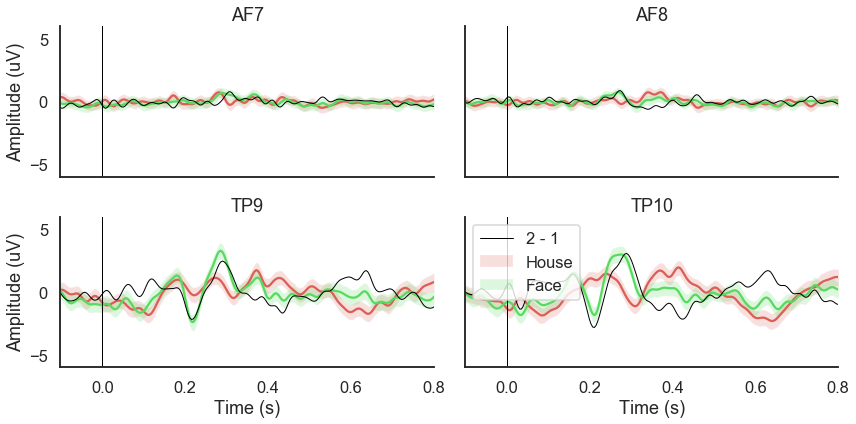

In [6]:
%matplotlib inline
conditions = OrderedDict()
conditions['House'] = [1]
conditions['Face'] = [2]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=(1, 2))

Decoding

In [7]:
import pandas as pd
from sklearn.pipeline import make_pipeline

from mne.decoding import Vectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from pyriemann.estimation import ERPCovariances, XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

from collections import OrderedDict

clfs = OrderedDict()

clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(estimator='oas'), MDM())
clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(estimator='oas'), MDM())

# format data
epochs.pick_types(eeg=True)
X = epochs.get_data() * 1e6
times = epochs.times
y = epochs.events[:, -1]

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.25, 
                            random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    print(m)
    try:
        
        res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', 
                              cv=cv, n_jobs=-1)
        auc.extend(res)
        methods.extend([m]*len(res))
    except:
        pass

Vect + LR
Vect + RegLDA
ERPCov + TS
ERPCov + MDM
XdawnCov + TS
XdawnCov + MDM


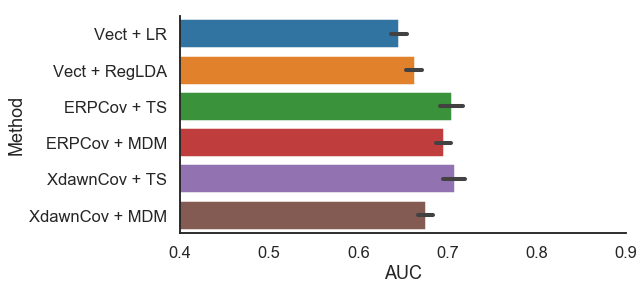

In [8]:
## Plot Decoding Results

import seaborn as sns
from matplotlib import pyplot as plt

    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

fig = plt.figure(figsize=[8,4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.4, 0.9)
sns.despine()